# tesseract-jax executes a CFD Tesseract

`cfd-tesseract` is a differentiable Navier-Stokes solver based on [JAX-CFD](https://github.com/google/jax-cfd) that is wrapped in a Tesseract. 

In [1]:
%%bash
# Build CFD Tesseract so we can use it below
tesseract build cfd-tesseract/

 [i] Building image ...
⠋ Processing
 [i] Built image sha256:0c56253398c1, ['jax-cfd:latest']


["jax-cfd:latest"]


In [2]:
# Install additional requirements
%pip install -r requirements.txt -q


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Let's set up the Tesseract with Tesseract-JAX and test a simple forward evaluation.

In [3]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tesseract_core import Tesseract

from tesseract_jax import apply_tesseract

seed = 0
size = 64
max_velocity = 3.0
domain_size_x = jnp.pi * 2
domain_size_y = jnp.pi * 2

grid = cfd.grids.Grid((size, size), domain=((0, domain_size_x), (0, domain_size_y)))
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity
)
vx, vy = v0

cfd_tesseract = Tesseract.from_image("jax-cfd")
cfd_tesseract.serve()

params = {
    "density": 1.0,
    "viscosity": 0.01,
    "inner_steps": 25,
    "outer_steps": 30,
    "max_velocity": max_velocity,
    "cfl_safety_factor": 0.5,
    "domain_size_x": domain_size_x,
    "domain_size_y": domain_size_y,
}

v0 = np.stack([np.array(vx.array.data), np.array(vy.array.data)], axis=-1)
cfd_tesseract_fn = lambda v0: apply_tesseract(
    cfd_tesseract, inputs=dict(v0=v0, **params)
)

outputs = cfd_tesseract_fn(v0)

Lets look at the results of the forward pass.

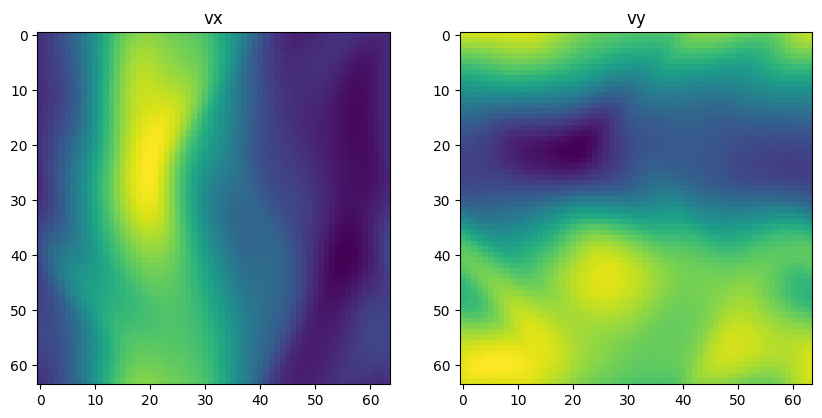

In [4]:
vxn = outputs["result"][..., 0]
vyn = outputs["result"][..., 1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(vxn, cmap="viridis")
ax[0].set_title("vx")
ax[1].imshow(vyn, cmap="viridis")
ax[1].set_title("vy")
plt.show()

In [5]:
bc = cfd.boundaries.HomogeneousBoundaryConditions(
    (
        (cfd.boundaries.BCType.PERIODIC, cfd.boundaries.BCType.PERIODIC),
        (cfd.boundaries.BCType.PERIODIC, cfd.boundaries.BCType.PERIODIC),
    )
)

And look at its vorticity field.

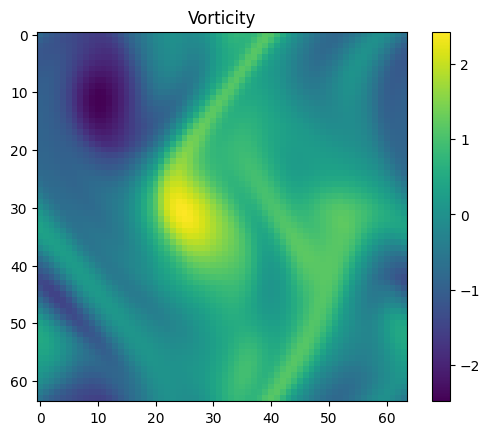

In [6]:
def vorticity(vxn, vyn):
    vxn = cfd.grids.GridArray(vxn, grid=grid, offset=(1.0, 0.5))
    vyn = cfd.grids.GridArray(vyn, grid=grid, offset=(0.5, 1.0))

    # reconstrut GridVariable from input
    vxn = cfd.grids.GridVariable(vxn, bc)
    vyn = cfd.grids.GridVariable(vyn, bc)

    # differntiate
    _, dvx_dy = cfd.finite_differences.central_difference(vxn)
    dvy_dx, _ = cfd.finite_differences.central_difference(vyn)

    return dvy_dx.data - dvx_dy.data


vort = vorticity(vxn, vyn)
plt.imshow(vort, cmap="viridis")
plt.title("Vorticity")
plt.colorbar()
plt.show()

## Optimization

Now we want to perform an actual optimization. The target is to find the initial state, such that the final state looks a bit like the logo of Pasteur Labs. Herefore we first load the logo.


-0.15707338 0.27429914


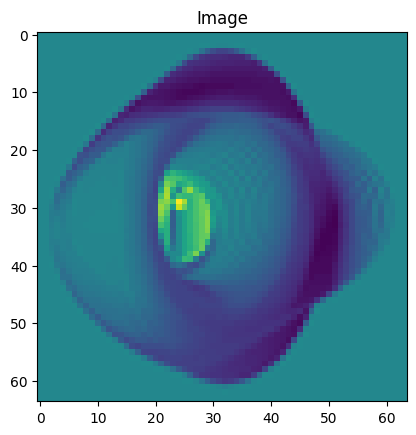

In [7]:
img = plt.imread("pl.png")
img = img.mean(axis=-1)
img = Image.fromarray((img * 255).astype(np.uint8))
img_shape_y, img_shape_x = img.size

img = img.resize((size, size))
img = np.array(img).astype(np.float32) / 255.0

# normalize around 0
img = img - img.mean()

plt.imshow(img, cmap="viridis")
plt.title("Image")

print(img.min(), img.max())

We define the loss function, which additionally ensures physical realism of initial condition by penalizing divergence.

In [8]:
def divergence(vxn, vyn):
    vxn = cfd.grids.GridArray(vxn, grid=grid, offset=(1.0, 0.5))
    vyn = cfd.grids.GridArray(vyn, grid=grid, offset=(0.5, 1.0))

    # reconstrut GridVariable from input
    vxn = cfd.grids.GridVariable(vxn, bc)
    vyn = cfd.grids.GridVariable(vyn, bc)

    return cfd.finite_differences.divergence([vxn, vyn]).data

In [9]:
def mse(x, y):
    return jnp.mean((x - y) ** 2)


def loss_fn(v0, img):
    v0x = v0[..., 0]
    v0y = v0[..., 1]

    div = divergence(v0x, v0y)

    vn = cfd_tesseract_fn(v0=v0)["result"]

    vxn = vn[..., 0]
    vyn = vn[..., 1]

    vort = vorticity(vxn, vyn)

    # decrase difference of vorticity and image and ensure the field is divergence free
    return mse(vort, img) + 0.05 * mse(div, 0.0)

Finally we perform the optimization with the help of the Adam optimizer as implemented in optax. This can take a few minutes.

In [10]:
import optax

learning_rate = 0.01
iterations = 400

optimizer = optax.adam(learning_rate)
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(221), grid, max_velocity
)
v0 = np.stack([np.array(vx.array.data), np.array(vy.array.data)], axis=-1)

opt_state = optimizer.init(v0)

# capture image in loss function
loss_fn_capt = lambda v0: loss_fn(v0, img=img)
grad_fn = jax.jit(jax.value_and_grad(loss_fn_capt))

for i in range(iterations):
    loss, grads = grad_fn(v0)

    print(f"Loss: {loss:.3f} Iteration: {i}")

    updates, opt_state = optimizer.update(grads, opt_state)

    v0 = optax.apply_updates(v0, updates)

Loss: 0.768 Iteration: 0
Loss: 0.750 Iteration: 1
Loss: 0.742 Iteration: 2
Loss: 0.736 Iteration: 3
Loss: 0.721 Iteration: 4
Loss: 0.707 Iteration: 5
Loss: 0.698 Iteration: 6
Loss: 0.690 Iteration: 7
Loss: 0.672 Iteration: 8
Loss: 0.655 Iteration: 9
Loss: 0.648 Iteration: 10
Loss: 0.645 Iteration: 11
Loss: 0.639 Iteration: 12
Loss: 0.632 Iteration: 13
Loss: 0.616 Iteration: 14
Loss: 0.602 Iteration: 15
Loss: 0.591 Iteration: 16
Loss: 0.584 Iteration: 17
Loss: 0.577 Iteration: 18
Loss: 0.571 Iteration: 19
Loss: 0.564 Iteration: 20
Loss: 0.558 Iteration: 21
Loss: 0.556 Iteration: 22
Loss: 0.554 Iteration: 23
Loss: 0.549 Iteration: 24
Loss: 0.545 Iteration: 25
Loss: 0.540 Iteration: 26
Loss: 0.535 Iteration: 27
Loss: 0.530 Iteration: 28
Loss: 0.525 Iteration: 29
Loss: 0.520 Iteration: 30
Loss: 0.515 Iteration: 31
Loss: 0.509 Iteration: 32
Loss: 0.504 Iteration: 33
Loss: 0.500 Iteration: 34
Loss: 0.496 Iteration: 35
Loss: 0.491 Iteration: 36
Loss: 0.487 Iteration: 37
Loss: 0.484 Iteration:

Let us now generate a video of the final result. Herefore we change the number of outer loops of the cfd simulation to 1, which enables us to save the state of the simulation at each time step.

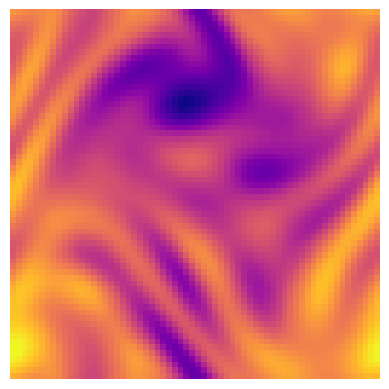

In [11]:
import matplotlib.animation as animation

trajectory = []

vi = v0.copy()

params_2 = params.copy()

params_2.update({"outer_steps": 1})
cfd_tesseract_fn_2 = lambda init: apply_tesseract(
    cfd_tesseract, inputs=dict(v0=init, **params_2)
)["result"]

for _ in range(30):
    vi = cfd_tesseract_fn_2(vi)

    vxn = vi[..., 0]
    vyn = vi[..., 1]

    vort = vorticity(vxn, vyn)

    trajectory.append(vort)

# repeat last frame a few times
trajectory.extend([vort] * 10)


fig = plt.figure()

ims = []
for _, vort in enumerate(trajectory):
    im = plt.imshow(vort, cmap="plasma", animated=True)
    # remove axis
    plt.axis("off")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

# store the animation as a gif
ani.save("vorticity.gif", writer="pillow")

In [12]:
cfd_tesseract.teardown()